# Target label definition

Describe the problem.

In [1]:
import pandas as pd
import os
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.modules.label_extraction as le
import src.modules.plotting as p
import importlib

importlib.reload(le);
importlib.reload(p);

- `df_fsr`: contains freesurfers information
- `df_cdr`: contains data about subjects' visit from which it is possible to extract the target label

In [2]:
df_fsr = pd.read_csv('../data/csv/OASIS3_Freesurfer_output.csv')
df_cdr = pd.read_csv('../data/csv/OASIS3_UDSb4_cdr.csv')

- Remove from `df_fsr` the labels related to empty freesurfers

In [3]:
df_fsr = df_fsr[~df_fsr['MR_session'].isin(os.listdir('../data/empty'))]

- Define a new column in `df_cdr` and `df_fsr` that encapsule the temporal information

In [4]:
df_cdr['time'] = le.get_time_column(df_cdr['OASIS_session_label'])
df_fsr['time'] = le.get_time_column(df_fsr['MR_session'])

- Checking negative time columns for `df_cdr`:

In [5]:
df_cdr[df_cdr['time'] < 0].shape[0]

5

- Checking negative time columns for `df_fsr`:

In [6]:
df_fsr[df_fsr['time'] < 0].shape[0]

0

## Fixing negative time columns

- Clearly OAS30753 is a mistake: the cdr is null for this patient and we can't infer about its possible dementia
- The other ones looks like errors in typing, they will be fixed

In [7]:
df_cdr[df_cdr['time'] < 0]

,OASISID,OASIS_session_label,days_to_visit,age at visit,MMSE,memory,orient,judgment,commun,homehobb,...,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5,time
1883,OAS30290,OAS30290_UDSb4_d-0002,-2,47.45,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,No dementia,.,.,.,.,-2
2116,OAS30330,OAS30330_UDSb4_d-0101,-101,80.53,24.0,0.5,0.5,0.0,0.0,0.5,...,NaN,NaN,NaN,NaN,"DLBD, primary",.,.,.,.,-101
2462,OAS30380,OAS30380_UDSb4_d-0015,-15,61.39,28.0,0.5,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,uncertain dementia,Active Other neurol/med diagnoses,.,.,.,-15
4914,OAS30753,OAS30753_UDSb4_d-39520,-39520,-47.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39520
5667,OAS30851,OAS30851_UDSb4_d-0001,-1,73.49,NaN,0.5,0.0,0.5,0.5,0.5,...,NaN,NaN,NaN,NaN,"Non DAT, Other primary",.,.,.,.,-1


- Remove the error instance

In [8]:
df_cdr = df_cdr.drop(index=4914)
df_fsr = df_fsr.drop(index=df_fsr[df_fsr['Subject'] == 'OAS30753'].index)

- Fix the column and subject label names

In [9]:
df_cdr[['OASIS_session_label', 'time']] = le.fix_negative_time_label(df_cdr, 'time', 'OASIS_session_label')

## Target mapping

In this section we extract some target columns from `df_cdr`, that needs to be correctly mapped inside `df_fsr` for each different subject, using the time periods extracted in the previous python cell.

- The first target it's the CDR column from `df_cdr`

In [10]:
df_fsr['CDR'] = le.get_mapped_target_column(
    df_cdr.rename(columns={'OASISID': 'Subject'}), 
    df_fsr, 
    'Subject',
    target_col_name='CDRTOT'
)

- The second target is the `dx1` column from `df_cdr`

In [11]:
df_fsr['DX'] = le.get_mapped_target_column(
    df_cdr.rename(columns={'OASISID': 'Subject'}), 
    df_fsr, 
    'Subject',
    target_col_name='dx1'
)

## Checking the alignment

- This function detect and corrects situation in which the CDR for a certain subject is not monotonically increasing due to errors in the dataset

In [12]:
df_fsr['CDR'] = le.align_labels(df_fsr, 'Subject', 'CDR')

- Same errors could be present in the diagnosis (dx) column. Before aligning the labels we need to translate this categorical column into a numeric colum

In [13]:
df_fsr['DX'].value_counts()

DX
Cognitively normal                       2009
AD Dementia                               232
uncertain dementia                        121
No dementia                                13
DLBD, primary                              12
AD dem w/depresss, not contribut           12
AD dem w/depresss, contribut                8
0.5 in memory only                          8
uncertain, possible NON AD dem              6
DAT                                         6
Frontotemporal demt. prim                   5
Unc: ques. Impairment                       5
AD dem Language dysf after                  5
AD dem Language dysf with                   4
AD dem w/PDI after AD dem not contrib       3
AD dem w/CVD not contrib                    3
Vascular Demt, primary                      3
AD dem w/oth (list B) not contrib           3
Dementia/PD, primary                        2
DAT Language dysf after                     2
AD dem w/oth (list B) contribut             2
AD dem Language dysf prior     

In [14]:
mapping = {'MCI': 1, 'Demented': 2, 'Non-Demented':0}

df_fsr['DX'] = le.simplify_diagnosis_label(
                    dx=df_fsr['DX'], 
                    non_dem=['Cognitively normal', 'No dementia'],
                    mapping_dict=mapping
                )

- Now we can align

In [15]:
df_fsr['DX'] = le.align_labels(df_fsr, 'Subject', 'DX')

- At this point we can extract the final labels

In [16]:
df_fsr['label'] = le.get_final_labels(
                        df=df_fsr, 
                        diagnosis_col_name='DX', 
                        cdr_col_name='CDR', 
                        mapping_dict=mapping,
                        reverse_mapping=True
)

- Label's distribution

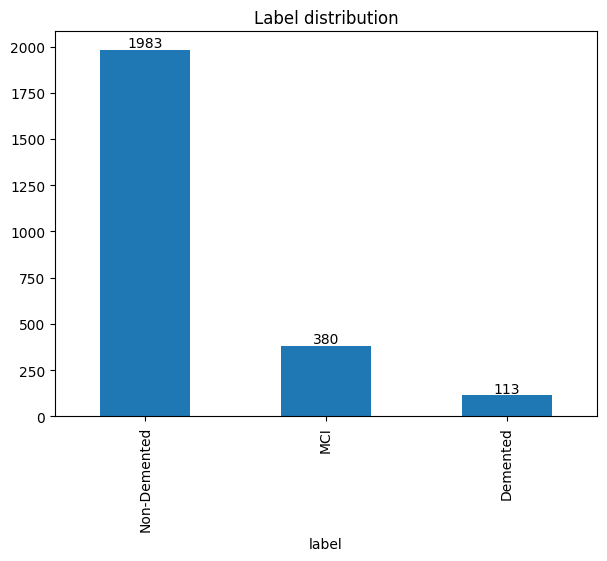

In [17]:
p.bar_plot(df_fsr['label'].value_counts(), 'Label distribution');

- Get the final dataset as a csv

In [24]:
df_fsr[[
    'Subject', 'TOTAL_HIPPOCAMPUS_VOLUME', 'Left-Hippocampus_volume', 
    'lh_parahippocampal_thickness', 'lh_parahippocampal_volume', 'rh_parahippocampal_volume',
    'rh_parahippocampal_thickness', 'Right-Hippocampus_volume'
]].to_csv('../data/csv/final_dataset.csv')